# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Features](#Features)
- [Clustering](#Clustering)
    - [4-Seam](#4-Seam-Fastball)
    - [Cutter](#Cutter)
    - [Sinker](#Sinker)
    - [Slider](#Slider)
    - [Curveball](#Curveball)
    - [Changeup](#Changeup)
- [Linear Regression Modeling](#Linear-Regression-Modeling)
    - [4-Seam](#Linear-Regression---4-Seam)
    - [Cutter](#Linear-Regression---Cutter)
    - [Sinker](#Linear-Regression---Sinker)
    - [Slider](#Linear-Regression---Slider)
    - [Curveball](#Linear-Regression---Curveball)
    - [Changeup](#Linear-Regression---Changeup)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(116889, 29)


,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,swing_miss,delta_run_exp,stand,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,xba,xwobacon,woba_value,woba_denom,babip_value,iso_value
0,L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,0,-0.073,R,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
4,L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,0,-0.189,L,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0
9,R,SI,94.3,1982.0,221.0,16.20,10.56,21.018028,94.4,-1.20,6.05,6.5,53.98,0.26,-0.26,1.78,0,-0.061,R,140.0,75.3,65.0,3.0,0.000,0.000,0.0,1.0,0.0,0.0
18,R,SL,90.5,2133.0,216.0,-0.12,7.44,23.569061,91.1,-1.51,5.93,6.3,54.23,-0.01,0.01,2.23,0,-0.173,L,294.0,96.8,18.0,4.0,0.409,0.457,0.0,1.0,0.0,0.0
27,R,FF,94.9,2224.0,216.0,9.00,14.16,23.435195,95.5,-2.71,6.38,6.6,53.86,0.10,-0.10,1.94,0,-0.163,R,308.0,91.8,29.0,3.0,0.109,0.156,0.0,1.0,0.0,0.0


In [3]:
# data['stand'] = data['stand'].map({'R': 0, 'L': 1})
# data['p_throws'] = data['p_throws'].map({'R': 0, 'L': 1})

# Drop pitch types Knuckle Curve and Splitter
# pitch = pitch[(pitch['pitch_type'] != 'KC') & (pitch['pitch_type'] != 'FS')]

Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

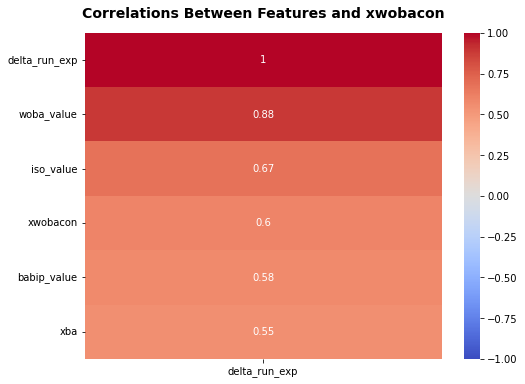

In [4]:
plt.figure(figsize = (8, 6))
sns.heatmap(data.corr()[['delta_run_exp']]
            [data.corr()['delta_run_exp'] > .5].sort_values('delta_run_exp', ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlations Between Features and xwobacon', fontsize = 14, fontweight = 'bold', pad = 15);

### Multicolinearity - VIF

In [5]:
features = data[['velo', 'pfx_-x', 'pfx_z', 'release_extension', 
                 'release_pos_z', 'woba_value', 'delta_run_exp', 'pitch_type', 'p_throws']]
# 'spin_rate'
features_vif = features.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features_vif.columns

vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]

vif_data.sort_values(by = 'VIF').head(8)

,feature,VIF
1,pfx_-x,1.094102
2,pfx_z,2.708317
6,delta_run_exp,4.621759
5,woba_value,6.533348
4,release_pos_z,96.464195
3,release_extension,150.538187
0,velo,221.647688


# Features

**Independent Variables:** Velocity, Spin Rate, VB, HB, Vertical Release Position, Release Extension

**Dependent Variable:** Launch Speed Angle

In [6]:
ff = features.loc[features['pitch_type'] == 'FF']
print('4-Seam shape:', ff.shape)
ff_r = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'R')]
print('RHP 4-Seam shape:', ff_r.shape)
ff_l = features.loc[(features['pitch_type'] == 'FF') & (features['p_throws'] == 'L')]
print('LHP 4-Seam shape:', ff_l.shape, '\n')
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
fc_r = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'R')]
print('RHP Cutter shape:', fc_r.shape)
fc_l = features.loc[(features['pitch_type'] == 'FC') & (features['p_throws'] == 'L')]
print('LHP Cutter shape:', fc_l.shape, '\n')
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
si_r = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'R')]
print('RHP Sinker shape:', si_r.shape)
si_l = features.loc[(features['pitch_type'] == 'SI') & (features['p_throws'] == 'L')]
print('LHP Sinker shape:', si_l.shape, '\n')
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
sl_r = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'R')]
print('RHP Slider shape:', sl_r.shape)
sl_l = features.loc[(features['pitch_type'] == 'SL') & (features['p_throws'] == 'L')]
print('LHP Slider shape:', sl_l.shape, '\n')
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
cu_r = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'R')]
print('RHP Curveball shape:', cu_r.shape)
cu_l = features.loc[(features['pitch_type'] == 'CU') & (features['p_throws'] == 'L')]
print('LHP Curveball shape:', cu_l.shape, '\n')
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)
ch_r = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'R')]
print('RHP Changeup shape:', ch_r.shape)
ch_l = features.loc[(features['pitch_type'] == 'CH') & (features['p_throws'] == 'L')]
print('LHP Changeup shape:', ch_l.shape)

4-Seam shape: (40378, 9)
RHP 4-Seam shape: (28478, 9)
LHP 4-Seam shape: (11900, 9) 

Cutter shape: (8698, 9)
RHP Cutter shape: (5588, 9)
LHP Cutter shape: (3110, 9) 

Sinker shape: (21979, 9)
RHP Sinker shape: (15373, 9)
LHP Sinker shape: (6606, 9) 

Slider shape: (21518, 9)
RHP Slider shape: (16153, 9)
LHP Slider shape: (5365, 9) 

Curveball shape: (8439, 9)
RHP Curveball shape: (5743, 9)
LHP Curveball shape: (2696, 9) 

Changeup shape: (15877, 9)
RHP Changeup shape: (9626, 9)
LHP Changeup shape: (6251, 9)


# Clustering

## 4-Seam

### RHP

In [7]:
features_ff_r = ff_r.select_dtypes([np.number])
X_ff_r = features_ff_r

ss = StandardScaler()
X_ff_r_scaled = ss.fit_transform(X_ff_r)
X_ff_r_scaled[:,:] *= -1

pca_ff_r = PCA().fit_transform(X_ff_r_scaled)
model_ff_r = pd.DataFrame(data = pca_ff_r, columns = X_ff_r.columns)

km_ff_r = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_r.fit(model_ff_r)
label_ff_r = km_ff_r.fit_predict(model_ff_r)

print('Number of iterations:', km_ff_r.n_iter_)
print('Number of features:', km_ff_r.n_features_in_)
print('Number of clusters:', km_ff_r.n_clusters)
print('Inertia:', km_ff_r.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_r[:10])

Number of iterations: 11
Number of features: 7
Number of clusters: 2
Inertia: 156633.1523840167 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0]


### LHP

In [8]:
features_ff_l = ff_l.select_dtypes([np.number])
X_ff_l = features_ff_l

ss = StandardScaler()
X_ff_l_scaled = ss.fit_transform(X_ff_l)
X_ff_l_scaled[:,:] *= -1

pca_ff_l = PCA().fit_transform(X_ff_l_scaled)
model_ff_l = pd.DataFrame(data = pca_ff_l, columns = X_ff_l.columns)

km_ff_l = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff_l.fit(model_ff_l)
label_ff_l = km_ff_l.fit_predict(model_ff_l)

print('Number of iterations:', km_ff_l.n_iter_)
print('Number of features:', km_ff_l.n_features_in_)
print('Number of clusters:', km_ff_l.n_clusters)
print('Inertia:', km_ff_l.inertia_, '\n')
print('Predicted clusters to points: ', label_ff_l[:10])

Number of iterations: 4
Number of features: 7
Number of clusters: 2
Inertia: 65417.91325848072 

Predicted clusters to points:  [1 1 1 0 0 1 1 0 1 0]


### Cluster Labels - RHP 4-Seam

In [9]:
X_ff_r['label'] = label_ff_r
model_ff_r['label'] = label_ff_r

X_ff_r.groupby(by = 'label').mean().T

label,0,1
velo,93.978226,93.945274
pfx_-x,7.092216,7.182650
pfx_z,15.746866,15.502953
release_extension,6.393605,6.387635
release_pos_z,5.892101,5.885367
woba_value,0.000817,1.178815
delta_run_exp,-0.255369,0.678571


### Cluster Labels - LHP 4-Seam

In [10]:
X_ff_l['label'] = label_ff_l
model_ff_l['label'] = label_ff_l

X_ff_l.groupby(by = 'label').mean().T

label,0,1
velo,92.643585,92.642353
pfx_-x,-7.509843,-7.326942
pfx_z,15.717971,15.831017
release_extension,6.286567,6.303389
release_pos_z,6.007804,6.000484
woba_value,1.161935,0.000464
delta_run_exp,0.662038,-0.258835


## Cutter

### RHP

In [11]:
features_fc_r = fc_r.select_dtypes([np.number])
X_fc_r = features_fc_r

X_fc_r_scaled = ss.fit_transform(X_fc_r)
X_fc_r_scaled[:,:] *= -1

pca_fc_r = PCA().fit_transform(X_fc_r_scaled)
model_fc_r = pd.DataFrame(data = pca_fc_r, columns = X_fc_r.columns)

km_fc_r = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_r.fit(model_fc_r)
label_fc_r = km_fc_r.fit_predict(model_fc_r)

print('Number of iterations:', km_fc_r.n_iter_)
print('Number of features:', km_fc_r.n_features_in_)
print('Number of clusters:', km_fc_r.n_clusters)
print('Inertia:', km_fc_r.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_r[:10])

Number of iterations: 6
Number of features: 7
Number of clusters: 2
Inertia: 30702.073668421912 

Predicted clusters to points:  [0 0 0 0 0 1 0 0 1 0]


### LHP

In [12]:
features_fc_l = fc_l.select_dtypes([np.number])
X_fc_l = features_fc_l

X_fc_l_scaled = ss.fit_transform(X_fc_l)
X_fc_l_scaled[:,:] *= -1

pca_fc_l = PCA().fit_transform(X_fc_l_scaled)
model_fc_l = pd.DataFrame(data = pca_fc_l, columns = X_fc_l.columns)

km_fc_l = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc_l.fit(model_fc_l)
label_fc_l = km_fc_r.fit_predict(model_fc_l)

print('Number of iterations:', km_fc_l.n_iter_)
print('Number of features:', km_fc_l.n_features_in_)
print('Number of clusters:', km_fc_l.n_clusters)
print('Inertia:', km_fc_l.inertia_, '\n')
print("Predicted clusters to points: ", label_fc_l[:10])

Number of iterations: 21
Number of features: 7
Number of clusters: 2
Inertia: 17030.757423404626 

Predicted clusters to points:  [1 1 0 0 1 1 1 1 1 0]


### Cluster Labels - RHP Cutter

In [13]:
X_fc_r['label'] = label_fc_r
model_fc_r['label'] = label_fc_r

X_fc_r.groupby(by = 'label').mean().T

label,0,1
velo,89.413584,89.344324
pfx_-x,-2.886181,-2.793308
pfx_z,7.811273,7.755481
release_extension,6.291540,6.285497
release_pos_z,5.958100,5.956507
woba_value,0.000000,1.134193
delta_run_exp,-0.266934,0.678753


### Cluster Labels - LHP Cutter

In [14]:
X_fc_l['label'] = label_fc_l
model_fc_l['label'] = label_fc_l

X_fc_l.groupby(by = 'label').mean().T

label,0,1
velo,86.737006,86.694618
pfx_-x,1.653964,1.588782
pfx_z,7.906075,8.000793
release_extension,6.193418,6.187347
release_pos_z,5.816660,5.797658
woba_value,0.000878,1.138102
delta_run_exp,-0.263264,0.675032


## Sinker

### RHP

In [15]:
features_si_r = si_r.select_dtypes([np.number])
X_si_r = features_si_r

X_si_r_scaled = ss.fit_transform(X_si_r)
X_si_r_scaled[:,:] *= -1

pca_si_r = PCA().fit_transform(X_si_r_scaled)
model_si_r = pd.DataFrame(data = pca_si_r, columns = X_si_r.columns)

km_si_r = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_r.fit(model_si_r)
label_si_r = km_si_r.fit_predict(model_si_r)

print('Number of iterations:', km_si_r.n_iter_)
print('Number of features:', km_si_r.n_features_in_)
print('Number of clusters:', km_si_r.n_clusters)
print('Inertia:', km_si_r.inertia_, '\n')
print("Predicted clusters to points: ", label_si_r[:10])

Number of iterations: 10
Number of features: 7
Number of clusters: 2
Inertia: 83930.04323295214 

Predicted clusters to points:  [0 0 0 1 0 0 1 0 0 1]


### LHP

In [16]:
features_si_l = si_l.select_dtypes([np.number])
X_si_l = features_si_l

X_si_l_scaled = ss.fit_transform(X_si_l)
X_si_l_scaled[:,:] *= -1

pca_si_l = PCA().fit_transform(X_si_l_scaled)
model_si_l = pd.DataFrame(data = pca_si_l, columns = X_si_l.columns)

km_si_l = KMeans(n_clusters = 2, 
                 random_state = 1)

km_si_l.fit(model_si_l)
label_si_l = km_si_l.fit_predict(model_si_l)

print('Number of iterations:', km_si_l.n_iter_)
print('Number of features:', km_si_l.n_features_in_)
print('Number of clusters:', km_si_l.n_clusters)
print('Inertia:', km_si_l.inertia_, '\n')
print("Predicted clusters to points: ", label_si_l[:10])

Number of iterations: 52
Number of features: 7
Number of clusters: 2
Inertia: 36146.11601223926 

Predicted clusters to points:  [1 1 1 0 1 0 1 0 1 0]


### Cluster Labels - RHP Sinker

In [17]:
X_si_r['label'] = label_si_r
model_si_r['label'] = label_si_r

X_si_r.groupby(by = 'label').mean().T

label,0,1
velo,93.396593,93.301061
pfx_-x,14.812364,14.672024
pfx_z,8.919766,8.823821
release_extension,6.309488,6.291490
release_pos_z,5.706021,5.702890
woba_value,0.000000,1.084638
delta_run_exp,-0.280965,0.630143


### Cluster Labels - LHP Sinker

In [18]:
X_si_l['label'] = label_si_l
model_si_l['label'] = label_si_l

X_si_l.groupby(by = 'label').mean().T

label,0,1
velo,91.979629,92.001405
pfx_-x,-14.873743,-14.963610
pfx_z,8.943526,8.930758
release_extension,6.274061,6.268639
release_pos_z,5.794384,5.786802
woba_value,1.089461,0.000000
delta_run_exp,0.614824,-0.272687


## Slider

### RHP

In [19]:
features_sl_r = sl_r.select_dtypes([np.number])
X_sl_r = features_sl_r

X_sl_r_scaled = ss.fit_transform(X_sl_r)
X_sl_r_scaled[:,:] *= -1

pca_sl_r = PCA().fit_transform(X_sl_r_scaled)
model_sl_r = pd.DataFrame(data = pca_sl_r, columns = X_sl_r.columns)

km_sl_r = KMeans(n_clusters = 2, random_state = 1)

km_sl_r.fit(model_sl_r)
label_sl_r = km_sl_r.fit_predict(model_sl_r)

print('Number of iterations:', km_sl_r.n_iter_)
print('Number of features:', km_sl_r.n_features_in_)
print('Number of clusters:', km_sl_r.n_clusters)
print('Inertia:', km_sl_r.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_r[:10])

Number of iterations: 4
Number of features: 7
Number of clusters: 2
Inertia: 88469.076642598 

Predicted clusters to points:  [1 1 0 0 0 1 1 1 1 0]


### LHP

In [20]:
features_sl_l = sl_l.select_dtypes([np.number])
X_sl_l = features_sl_l

X_sl_l_scaled = ss.fit_transform(X_sl_l)
X_sl_l_scaled[:,:] *= -1

pca_sl_l = PCA().fit_transform(X_sl_l_scaled)
model_sl_l = pd.DataFrame(data = pca_sl_l, columns = X_sl_l.columns)

km_sl_l = KMeans(n_clusters = 2, random_state = 1)

km_sl_l.fit(model_sl_l)
label_sl_l = km_sl_l.fit_predict(model_sl_l)

print('Number of iterations:', km_sl_l.n_iter_)
print('Number of features:', km_sl_l.n_features_in_)
print('Number of clusters:', km_sl_l.n_clusters)
print('Inertia:', km_sl_l.inertia_, '\n')
print("Predicted clusters to points: ", label_sl_l[:10])

Number of iterations: 5
Number of features: 7
Number of clusters: 2
Inertia: 29452.668420048758 

Predicted clusters to points:  [0 0 1 1 1 1 0 1 1 1]


### Cluster Labels - RHP Slider

In [21]:
X_sl_r['label'] = label_sl_r
model_sl_r['label'] = label_sl_r

X_sl_r.groupby(by = 'label').mean().T

label,0,1
velo,84.901012,84.816523
pfx_-x,-5.939759,-6.182077
pfx_z,1.659415,1.898809
release_extension,6.247985,6.255532
release_pos_z,5.798489,5.770381
woba_value,1.155339,0.000824
delta_run_exp,0.725874,-0.248304


### Cluster Labels - LHP Slider

In [22]:
X_sl_l['label'] = label_sl_l
model_sl_l['label'] = label_sl_l

X_sl_l.groupby(by = 'label').mean().T

label,0,1
velo,83.927526,83.899251
pfx_-x,5.331555,5.499384
pfx_z,1.511305,1.471507
release_extension,6.243019,6.230031
release_pos_z,5.875142,5.885673
woba_value,1.154115,0.000999
delta_run_exp,0.737843,-0.245255


## Curveball

### RHP

In [23]:
features_cu_r = cu_r.select_dtypes([np.number])
X_cu_r = features_cu_r

X_cu_r_scaled = ss.fit_transform(X_cu_r)
X_cu_r_scaled[:,:] *= -1

pca_cu_r = PCA().fit_transform(X_cu_r_scaled)
model_cu_r = pd.DataFrame(data = pca_cu_r, columns = X_cu_r.columns)

km_cu_r = KMeans(n_clusters = 2, random_state = 1)

km_cu_r.fit(model_cu_r)
label_cu_r = km_cu_r.fit_predict(model_cu_r)

print('Number of iterations:', km_cu_r.n_iter_)
print('Number of features:', km_cu_r.n_features_in_)
print('Number of clusters:', km_cu_r.n_clusters)
print('Inertia:', km_cu_r.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_r[:10])

Number of iterations: 6
Number of features: 7
Number of clusters: 2
Inertia: 31433.589121948484 

Predicted clusters to points:  [1 0 1 1 1 1 1 1 0 1]


### LHP

In [24]:
features_cu_l = cu_l.select_dtypes([np.number])
X_cu_l = features_cu_l

X_cu_l_scaled = ss.fit_transform(X_cu_l)
X_cu_l_scaled[:,:] *= -1

pca_cu_l = PCA().fit_transform(X_cu_l_scaled)
model_cu_l = pd.DataFrame(data = pca_cu_l, columns = X_cu_l.columns)

km_cu_l = KMeans(n_clusters = 2, random_state = 1)

km_cu_l.fit(model_cu_l)
label_cu_l = km_cu_l.fit_predict(model_cu_l)

print('Number of iterations:', km_cu_l.n_iter_)
print('Number of features:', km_cu_l.n_features_in_)
print('Number of clusters:', km_cu_l.n_clusters)
print('Inertia:', km_cu_l.inertia_, '\n')
print("Predicted clusters to points: ", label_cu_l[:10])

Number of iterations: 30
Number of features: 7
Number of clusters: 2
Inertia: 14754.897549455518 

Predicted clusters to points:  [1 0 1 0 1 1 1 1 1 0]


### Cluster Labels - RHP Curveball

In [25]:
X_cu_r['label'] = label_cu_r
model_cu_r['label'] = label_cu_r

X_cu_r.groupby(by = 'label').mean().T

label,0,1
velo,79.013088,79.033945
pfx_-x,-9.439808,-9.855438
pfx_z,-9.481154,-9.278657
release_extension,6.227030,6.238026
release_pos_z,5.971368,5.970351
woba_value,1.129327,0.000465
delta_run_exp,0.694390,-0.230715


### Cluster Labels - LHP Curveball

In [26]:
X_cu_l['label'] = label_cu_l
model_cu_l['label'] = label_cu_l

X_cu_l.groupby(by = 'label').mean().T

label,0,1
velo,77.534599,77.567587
pfx_-x,8.011627,8.678219
pfx_z,-7.451974,-7.079594
release_extension,6.117028,6.105468
release_pos_z,6.003167,5.971866
woba_value,1.119360,0.000000
delta_run_exp,0.687682,-0.229039


## Changeup

### RHP

In [27]:
features_ch_r = ch_r.select_dtypes([np.number])
X_ch_r = features_ch_r

X_ch_r_scaled = ss.fit_transform(X_ch_r)
X_ch_r_scaled[:,:] *= -1

pca_ch_r = PCA().fit_transform(X_ch_r)
model_ch_r = pd.DataFrame(data = pca_ch_r, columns = X_ch_r.columns)

km_ch_r = KMeans(n_clusters = 2, random_state = 1)

km_ch_r.fit(model_ch_r)
label_ch_r = km_ch_r.fit_predict(model_ch_r)

print('Number of iterations:', km_ch_r.n_iter_)
print('Number of features:', km_ch_r.n_features_in_)
print('Number of clusters:', km_ch_r.n_clusters)
print('Inertia:', km_ch_r.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_r[:10])

Number of iterations: 13
Number of features: 7
Number of clusters: 2
Inertia: 334793.6848827029 

Predicted clusters to points:  [0 0 0 0 0 1 1 1 1 0]


### LHP

In [28]:
features_ch_l = ch_l.select_dtypes([np.number])
X_ch_l = features_ch_l

X_ch_l_scaled = ss.fit_transform(X_ch_l)
X_ch_l_scaled[:,:] *= -1

pca_ch_l = PCA().fit_transform(X_ch_l)
model_ch_l = pd.DataFrame(data = pca_ch_l, columns = X_ch_l.columns)

km_ch_l = KMeans(n_clusters = 2, random_state = 1)

km_ch_l.fit(model_ch_l)
label_ch_l = km_ch_l.fit_predict(model_ch_l)

print('Number of iterations:', km_ch_l.n_iter_)
print('Number of features:', km_ch_l.n_features_in_)
print('Number of clusters:', km_ch_l.n_clusters)
print('Inertia:', km_ch_l.inertia_, '\n')
print("Predicted clusters to points: ", label_ch_l[:10])

Number of iterations: 11
Number of features: 7
Number of clusters: 2
Inertia: 171241.9071989997 

Predicted clusters to points:  [0 1 1 1 0 1 0 1 0 1]


### Cluster Labels - RHP Changeup

In [29]:
X_ch_r['label'] = label_ch_r
model_ch_r['label'] = label_ch_r

X_ch_r.groupby(by = 'label').mean().T

label,0,1
velo,85.909021,85.022061
pfx_-x,14.108247,13.307053
pfx_z,2.253084,9.965883
release_extension,6.281372,6.358908
release_pos_z,5.599507,5.944572
woba_value,0.362081,0.355790
delta_run_exp,0.050817,0.040807


### Cluster Labels - LHP Changeup

In [30]:
X_ch_l['label'] = label_ch_l
model_ch_l['label'] = label_ch_l

X_ch_l.groupby(by = 'label').mean().T

label,0,1
velo,83.465715,83.509896
pfx_-x,-12.436313,-14.869338
pfx_z,11.854038,4.789962
release_extension,6.254454,6.220312
release_pos_z,6.027952,5.697791
woba_value,0.360663,0.350519
delta_run_exp,0.048509,0.037952


# Linear Regression Modeling

## Linear Regression - 4-Seam

### RHP

In [31]:
X = X_ff_r.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ff_r['delta_run_exp']

ols_ff_r = sm.OLS(y, X).fit()
pred_ff_r = ols_ff_r.predict(X)
fitted_vals_ff_r = ols_ff_r.fittedvalues
residuals_ff_r = ols_ff_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_r), 4))
print(ols_ff_r.summary())

MSE: 0.0644
RMSE: 0.2538
MAE: 0.1708
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 1.481e+04
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:13   Log-Likelihood:                -1354.0
No. Observations:               28478   AIC:                             2724.
Df Residuals:                   28470   BIC:                             2790.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

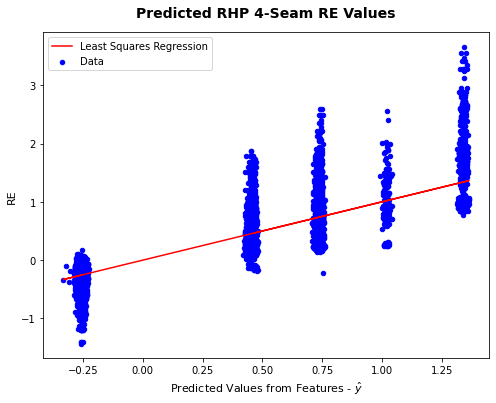

In [32]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_r, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_r, np.poly1d(np.polyfit(pred_ff_r, y, 1))(pred_ff_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted RHP 4-Seam RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

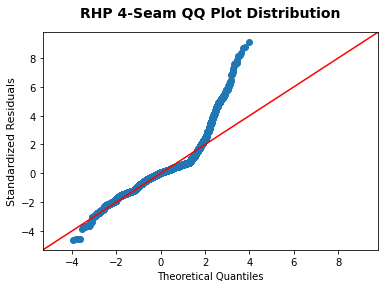

In [33]:
sm.qqplot(residuals_ff_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [34]:
X = X_ff_l.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ff_l['delta_run_exp']

ols_ff_l = sm.OLS(y, X).fit()
pred_ff_l = ols_ff_l.predict(X)
fitted_vals_ff_l = ols_ff_l.fittedvalues
residuals_ff_l = ols_ff_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ff_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff_l), 4))
print(ols_ff_l.summary())

MSE: 0.0642
RMSE: 0.2535
MAE: 0.1725
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     6016.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:14   Log-Likelihood:                -552.60
No. Observations:               11900   AIC:                             1121.
Df Residuals:                   11892   BIC:                             1180.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

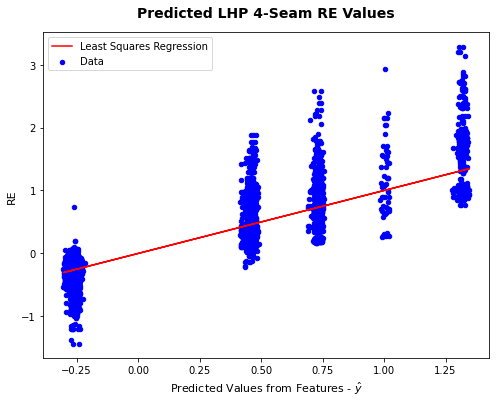

In [35]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_ff_l, y, s = 20, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ff_l, np.poly1d(np.polyfit(pred_ff_l, y, 1))(pred_ff_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted LHP 4-Seam RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

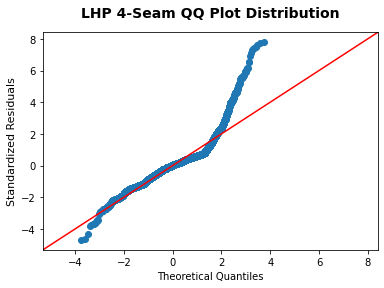

In [36]:
sm.qqplot(residuals_ff_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP 4-Seam QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Cutter

### RHP

In [37]:
X = X_fc_r.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_fc_r['delta_run_exp']

ols_fc_r = sm.OLS(y, X).fit()
pred_fc_r = ols_fc_r.predict(X)
fitted_vals_fc_r = ols_fc_r.fittedvalues
residuals_fc_r = ols_fc_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_r), 4))
print(ols_fc_r.summary())

MSE: 0.0656
RMSE: 0.256
MAE: 0.1763
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2881.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:14   Log-Likelihood:                -315.60
No. Observations:                5588   AIC:                             647.2
Df Residuals:                    5580   BIC:                             700.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

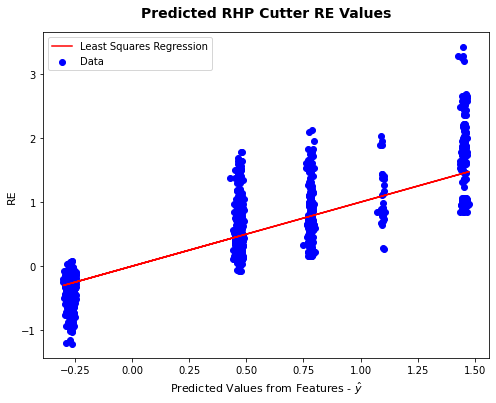

In [38]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_r, np.poly1d(np.polyfit(pred_fc_r, y, 1))(pred_fc_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted RHP Cutter RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

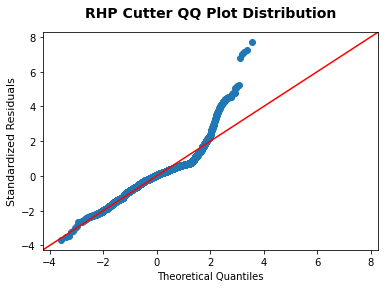

In [39]:
sm.qqplot(residuals_fc_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [40]:
X = X_fc_l.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_fc_l['delta_run_exp']

ols_fc_l = sm.OLS(y, X).fit()
pred_fc_l = ols_fc_l.predict(X)
fitted_vals_fc_l = ols_fc_l.fittedvalues
residuals_fc_l = ols_fc_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_fc_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc_l), 4))
print(ols_fc_l.summary())

MSE: 0.0663
RMSE: 0.2574
MAE: 0.1776
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     1526.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:14   Log-Likelihood:                -192.48
No. Observations:                3110   AIC:                             401.0
Df Residuals:                    3102   BIC:                             449.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

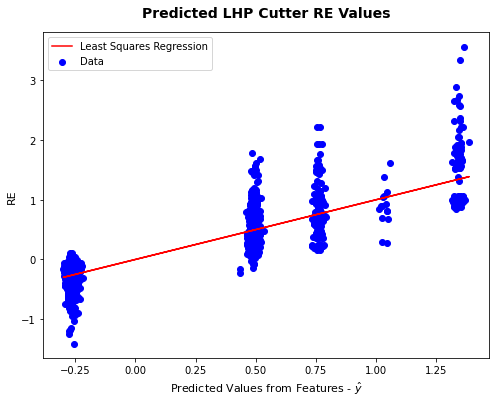

In [41]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_fc_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_fc_l, np.poly1d(np.polyfit(pred_fc_l, y, 1))(pred_fc_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted LHP Cutter RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

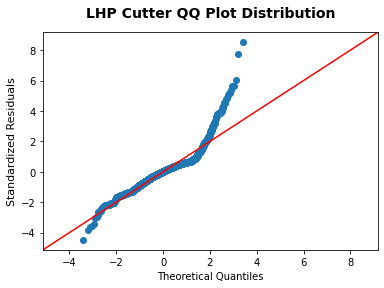

In [42]:
sm.qqplot(residuals_fc_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Cutter QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Sinker

### RHP

In [43]:
X = X_si_r.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_si_r['delta_run_exp']

ols_si_r = sm.OLS(y, X).fit()
pred_si_r = ols_si_r.predict(X)
fitted_vals_si_r = ols_si_r.fittedvalues
residuals_si_r = ols_si_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_r), 4))
print(ols_si_r.summary())

MSE: 0.0617
RMSE: 0.2484
MAE: 0.175
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     7691.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:14   Log-Likelihood:                -404.83
No. Observations:               15373   AIC:                             825.7
Df Residuals:                   15365   BIC:                             886.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

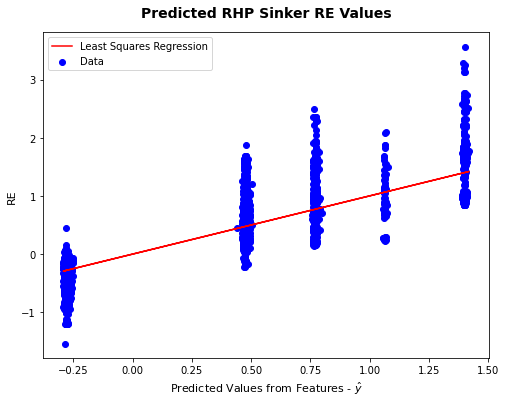

In [44]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_r, np.poly1d(np.polyfit(pred_si_r, y, 1))(pred_si_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted RHP Sinker RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

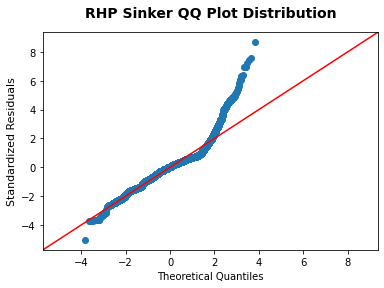

In [45]:
sm.qqplot(residuals_si_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [46]:
X = X_si_l.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_si_l['delta_run_exp']

ols_si_l = sm.OLS(y, X).fit()
pred_si_l = ols_si_l.predict(X)
fitted_vals_si_l = ols_si_l.fittedvalues
residuals_si_l = ols_si_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_si_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si_l), 4))
print(ols_si_l.summary())

MSE: 0.0611
RMSE: 0.2471
MAE: 0.1733
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     3160.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:15   Log-Likelihood:                -138.23
No. Observations:                6606   AIC:                             292.5
Df Residuals:                    6598   BIC:                             346.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

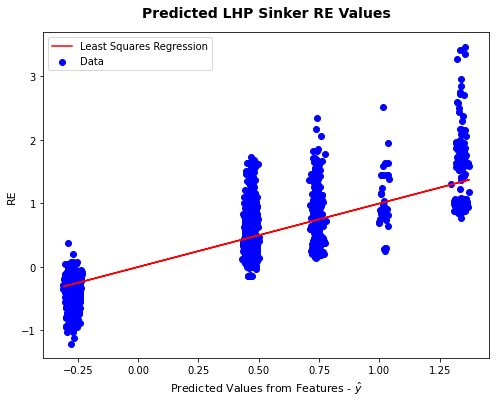

In [47]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_si_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_si_l, np.poly1d(np.polyfit(pred_si_l, y, 1))(pred_si_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted LHP Sinker RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

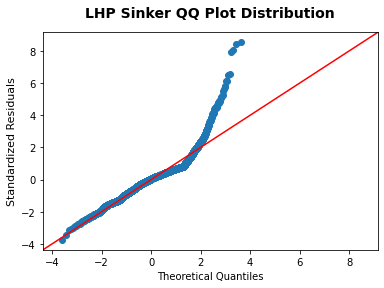

In [48]:
sm.qqplot(residuals_si_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Sinker QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Slider

### RHP

In [49]:
X = X_sl_r.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_sl_r['delta_run_exp']

ols_sl_r = sm.OLS(y, X).fit()
pred_sl_r = ols_sl_r.predict(X)
fitted_vals_sl_r = ols_sl_r.fittedvalues
residuals_sl_r = ols_sl_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_r), 4))
print(ols_sl_r.summary())

MSE: 0.067
RMSE: 0.2588
MAE: 0.1763
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     8371.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:15   Log-Likelihood:                -1086.6
No. Observations:               16153   AIC:                             2189.
Df Residuals:                   16145   BIC:                             2251.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
co

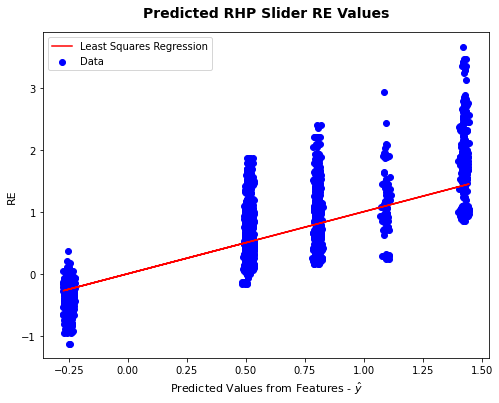

In [50]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_r, np.poly1d(np.polyfit(pred_sl_r, y, 1))(pred_sl_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted RHP Slider RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

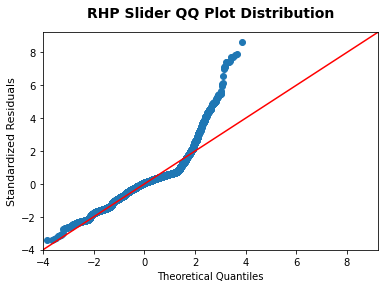

In [51]:
sm.qqplot(residuals_sl_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [52]:
X = X_sl_l.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_sl_l['delta_run_exp']

ols_sl_l = sm.OLS(y, X).fit()
pred_sl_l = ols_sl_l.predict(X)
fitted_vals_sl_l = ols_sl_l.fittedvalues
residuals_sl_l = ols_sl_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_sl_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl_l), 4))
print(ols_sl_l.summary())

MSE: 0.0704
RMSE: 0.2653
MAE: 0.1802
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     2733.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:15   Log-Likelihood:                -494.06
No. Observations:                5365   AIC:                             1004.
Df Residuals:                    5357   BIC:                             1057.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

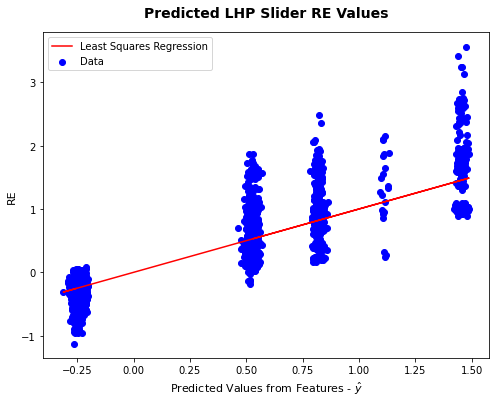

In [53]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_sl_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_sl_l, np.poly1d(np.polyfit(pred_sl_l, y, 1))(pred_sl_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted LHP Slider RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

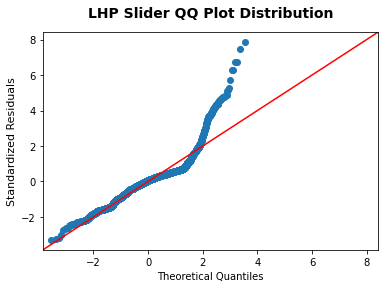

In [54]:
sm.qqplot(residuals_sl_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Slider QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Curveball

### RHP

In [55]:
X = X_cu_r.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_cu_r['delta_run_exp']

ols_cu_r = sm.OLS(y, X).fit()
pred_cu_r = ols_cu_r.predict(X)
fitted_vals_cu_r = ols_cu_r.fittedvalues
residuals_cu_r = ols_cu_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_r), 4))
print(ols_cu_r.summary())

MSE: 0.0622
RMSE: 0.2495
MAE: 0.1645
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2900.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:16   Log-Likelihood:                -175.17
No. Observations:                5743   AIC:                             366.3
Df Residuals:                    5735   BIC:                             419.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

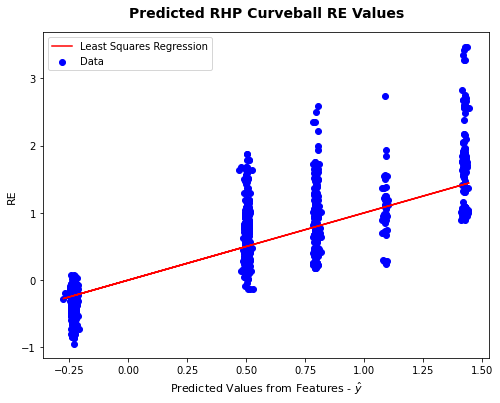

In [56]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_r, np.poly1d(np.polyfit(pred_cu_r, y, 1))(pred_cu_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted RHP Curveball RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

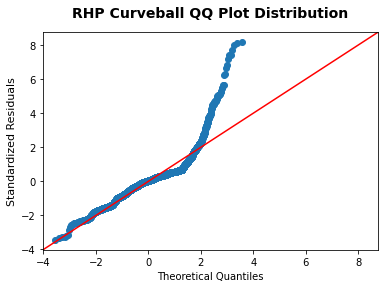

In [57]:
sm.qqplot(residuals_cu_r, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [58]:
X = X_cu_l.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_cu_l['delta_run_exp']

ols_cu_l = sm.OLS(y, X).fit()
pred_cu_l = ols_cu_l.predict(X)
fitted_vals_cu_l = ols_cu_l.fittedvalues
residuals_cu_l = ols_cu_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_cu_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu_l), 4))
print(ols_cu_l.summary())

MSE: 0.0613
RMSE: 0.2476
MAE: 0.1668
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1396.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:16   Log-Likelihood:                -61.501
No. Observations:                2696   AIC:                             139.0
Df Residuals:                    2688   BIC:                             186.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

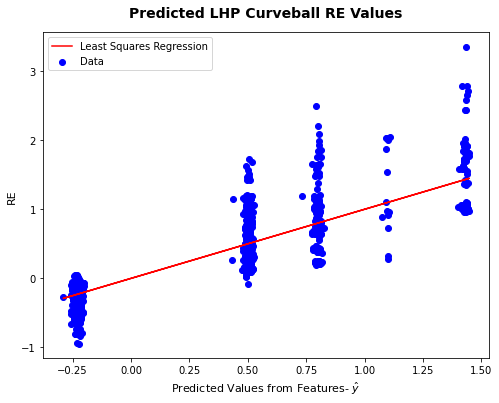

In [59]:
plt.figure(figsize = (8, 6))

plt.scatter(pred_cu_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_cu_l, np.poly1d(np.polyfit(pred_cu_l, y, 1))(pred_cu_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features- $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted LHP Curveball RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

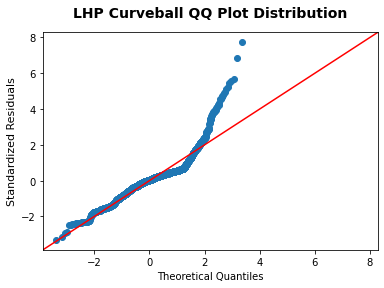

In [60]:
sm.qqplot(residuals_cu_l, line='45', fit=True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Curveball QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

## Linear Regression - Changeup

### RHP

In [61]:
X = X_ch_r.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ch_r['delta_run_exp']

ols_ch_r = sm.OLS(y, X).fit()
pred_ch_r = ols_ch_r.predict(X)
fitted_vals_ch_r = ols_ch_r.fittedvalues
residuals_ch_r = ols_ch_r.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_r), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_r)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_r), 4))
print(ols_ch_r.summary())

MSE: 0.0578
RMSE: 0.2404
MAE: 0.1659
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     5260.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:16   Log-Likelihood:                 64.085
No. Observations:                9626   AIC:                            -112.2
Df Residuals:                    9618   BIC:                            -54.79
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

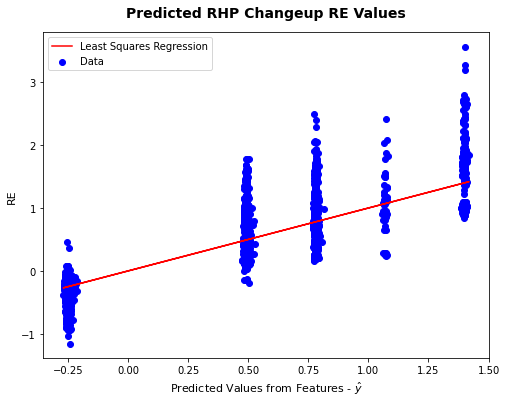

In [62]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_r, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_r, np.poly1d(np.polyfit(pred_ch_r, y, 1))(pred_ch_r), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted RHP Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

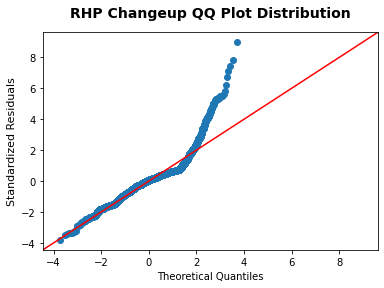

In [63]:
sm.qqplot(residuals_ch_r, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('RHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP

In [64]:
X = X_ch_l.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ch_l['delta_run_exp']

ols_ch_l = sm.OLS(y, X).fit()
pred_ch_l = ols_ch_l.predict(X)
fitted_vals_ch_l = ols_ch_l.fittedvalues
residuals_ch_l = ols_ch_l.resid

print('MSE:', round(metrics.mean_squared_error(y, pred_ch_l), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch_l)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch_l), 4))
print(ols_ch_l.summary())

MSE: 0.0584
RMSE: 0.2416
MAE: 0.1673
                            OLS Regression Results                            
Dep. Variable:          delta_run_exp   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     3252.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:59:16   Log-Likelihood:                 10.065
No. Observations:                6251   AIC:                            -4.131
Df Residuals:                    6243   BIC:                             49.79
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
c

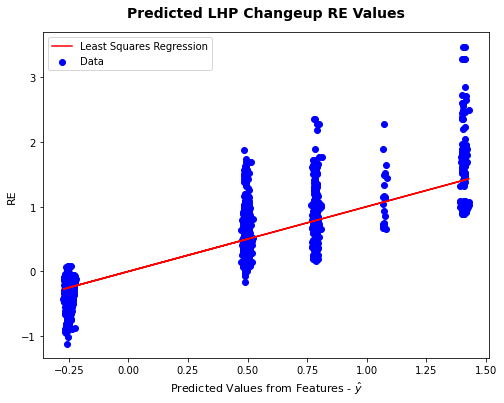

In [65]:
plt.figure(figsize = (8, 6))
plt.scatter(pred_ch_l, y, c = 'b', marker = 'o', label = 'Data')
plt.plot(pred_ch_l, np.poly1d(np.polyfit(pred_ch_l, y, 1))(pred_ch_l), c = 'r',label = 'Least Squares Regression')
plt.legend()
plt.xlabel('Predicted Values from Features - $\hat{y}$', fontsize = 11), plt.ylabel('RE', fontsize = 11)
plt.title('Predicted LHP Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15);

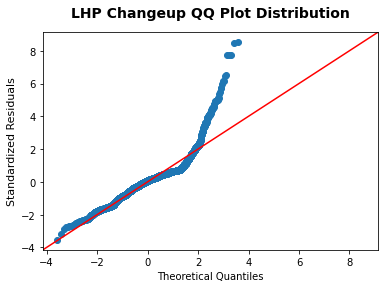

In [66]:
sm.qqplot(residuals_ch_l, line = '45', fit = True)
plt.ylabel('Standardized Residuals', fontsize = 11)
plt.title('LHP Changeup QQ Plot Distribution', fontsize = 14, fontweight = 'bold', pad = 15);